<H1> Nombre:</H1>
<H1> Apellido:</H1>
<H1> Número de alumno:</H1>

#Pregunta 1

#Pregunta 2

#Pregunta 3

#Pregunta 4

#AR - demo

In [ ]:
#Descarga del ambiente (RUN ME!)
%%bash
pip install gym pyvirtualdisplay > /dev/null 2>&1
apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
apt-get update > /dev/null 2>&1
apt-get install cmake > /dev/null 2>&1
pip install --upgrade setuptools 2>&1
pip install ez_setup > /dev/null 2>&1
pip install gym[atari] > /dev/null 2>&1
pip3 install box2d-py

Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (57.0.0)


In [ ]:
#@title Importes (RUN ME TOO!)
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Vamos a inicializar el ambiente

In [ ]:
env = gym.make('CartPole-v1')

Cada vez que se resetea el ambiente se envía una observación del estado en el que inicia la nueva instancia.

In [ ]:
obs = env.reset()
print(obs)

[ 0.02696683 -0.02860931 -0.00570075  0.03795271]


Estos son los estados de ciertas variables importantes, para el ambiente. En ese caso estamos utilizando el ambiente ```CartPole-v1```. Según la [wiki](https://github.com/openai/gym/wiki/CartPole-v0) del toolkit las observaciones del sistema son: <p>

>Num | Observations | Min | Max
>--- | --- | ---  | ---
>0 | Cart Position | -2.4 | 2.4
>1 | Cart Velocity | -Inf | Inf
>2 | Pole Angle | ~-41.8° | ~41.8°
>3 | Pole Velocity at tip | -Inf | Inf


In [ ]:
print('Su espacio de acciones es', env.action_space)

Su espacio de acciones es Discrete(2)


En pocas palabras

>Num | Action
>--- | --- 
>0 | Push car to left
>1 | Push car to right

Cada vez que se carga el ambiente se inicializa en algún estado aleatorio, con el péndulo en posición vertical. Veamos dos ejemplos.

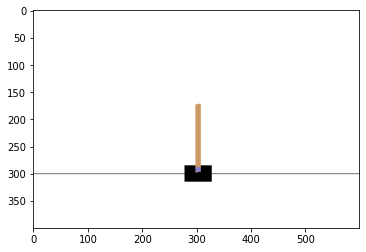

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(env.render(mode='rgb_array'));

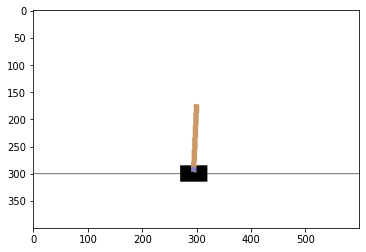

In [ ]:
env.reset()
plt.imshow(env.render(mode='rgb_array'));

La diferencia es sutil, esto pues este ambiente tiene un desafío como diseño. Hay que mantener el péndulo vertical tanto como se pueda. Luego de eso el ambiente termina. <br>
Ambientes como éste se denominan episódicos. Y tienden a funcionar en series de episodios. Muchos juegos caen en esta categoría, juegos de atari como pacman, o incluso juegos analógicos como el ajedrés también son episódicos.<br>
Los episodios de este ambiente terminan si:


*   El ángulo del péndulo es mayor a $\pm 12°$
*   La posición del carro es mayor a $\pm 2.4$
*   El largo del episodio es mayor a 500



Cada ambiente puede enviar una secuencia de acciones aleatorias si se le desea.

In [ ]:
[env.action_space.sample() for _ in range(10)]

[0, 1, 0, 1, 1, 1, 0, 1, 0, 1]

Calculemos cuantas acciones de "ir a la izquierda" puede tomar en promedio el sistema antes de que termine el episodio.

In [ ]:
def actions_till_done(env, action):
    env.reset()
    done = False
    count = 0
    while done == False:
        _, _, done, _, = env.step(action)
        count += 1
    return count
  
# Get an estimate for how many 0 actions you can take on average before the 
# pole falls over
np.mean([actions_till_done(env, 0) for _ in range(100)])

9.32

De la misma manera se puede definir un criterio que calcule la cantidad de recompensas que se pueden obtener por episodio en promedio.

In [ ]:
def average_episodic_return(env, agent, episodes=10, max_steps_per_episode=500):
    episode_rewards = []
    for episode in range(episodes):
        total_rewards = 0
        obs = env.reset()
        for t in range(max_steps_per_episode):
            out = agent(obs) # we don't care about the probabilities here
            assert ("Action" in out), "The key 'Action' was missing from the agents output."
            obs, rew, done, _ = env.step(out["Action"])
            total_rewards += rew
            # check if we are done, if so, exit loop
            if done:
                break
                
        episode_rewards.append(total_rewards)
        
    return {
        "AverageEpisodicReturn": np.mean(episode_rewards), 
        "StandardDeviation":np.sqrt(np.var(episode_rewards))
    }

In [ ]:
def agent_left(observation):
    return {"Action":0}

In [ ]:
average_episodic_return(env, agent_left)

{'AverageEpisodicReturn': 9.5, 'StandardDeviation:.4': 0.6708203932499369}

De la misma forma que pudimos mostrar una imagen de un estado del agente se puede presentar al agente en una secuencia animada.

In [ ]:
from collections import deque
import matplotlib.animation
import matplotlib.pyplot as plt
%matplotlib inline

def animate_agent(env, agent, max_steps = 400):
    obs = env.reset()
    frames = deque()
    frames.append(env.render(mode='rgb_array'))
    for _ in range(max_steps):
        out = agent(obs)
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]
        obs, _ , done, _ = env.step(action)
        frames.append(env.render(mode='rgb_array'))
        if done:
            break
            
    return animate_frames(frames)

def animate_frames(frames):
    new_height = 2.2
    original_height = frames[0].shape[0]
    original_width = frames[0].shape[1]
    new_width = (new_height / original_height) * original_width
    fig = plt.figure(figsize=(new_width, new_height), dpi = 120)
    
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    patch = ax.imshow(frames[0], aspect='auto', animated=True, interpolation='bilinear')
    animate = lambda i: patch.set_data(frames[i])
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames), interval = 50)
    
    plt.close()
    return HTML(ani.to_jshtml())

¿Cómo se ve el agente cuando se le da la orden de ir siempre a la izquierda?

In [ ]:
def agent_left(observation):
    return {"Action":0}
  
animate_agent(env, agent_left, max_steps = 400)

¿Y si se envía una orden aleatoria para que se mueva a izquierda o derecha?

In [ ]:
def agent_random(observation):
    return {"Action":np.random.choice([0, 1])}

In [ ]:
average_episodic_return(env, agent_random)

{'AverageEpisodicReturn': 23.7, 'StandardDeviation': 12.712592182556632}

In [ ]:
animate_agent(env, agent_random)

Podemos definir una función que discretice el valor del estado en caso de que necesitasemos un valor en este dominio.

In [ ]:
def state_for(observation):
    ranges = [np.arange(-1, 1.25, 0.25), np.arange(-0.3, 0.375, 0.075)[:9], np.arange(-1, 1.25, 0.25)]
    state = np.zeros((3,)) #Ignorando el primer sensor
    for i, (obs, limits) in enumerate(zip(observation[1:], ranges)):
        if obs < limits[0]:
            state[i] = 0
            continue
        for j in range(1, len(limits) - 1):
            if limits[j] <= obs <= limits[j+1]:
                state[i] = j
                break
        if obs > limits[len(limits) - 1]:  
            state[i] = len(limits)

    currstate = 0

    for i in range(3): 
        currstate += state[i] * (10 ** i)

    return int(currstate)


Este es un ejemplo del carro cuando ha sido entrenado correctamente un agente utilizando q learning.

In [ ]:
animate_agent(env, agent)

In [ ]:
average_episodic_return(env, agent)

{'AverageEpisodicReturn': 114.7, 'StandardDeviation': 63.86869342643546}

#Pregunta 5

In [ ]:
env = gym.make('Pendulum-v0')

#Pregunta 6

#Pregunta 7 (BONO)